In [ ]:
#==========================================
# Title:  Options Price (Call) Predictor using MLP1 Model
# Author: Vachan
# Email : vachan@iitb.ac.in
#==========================================

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras import backend
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import norm
import numpy as np

In [2]:
excel_file = pd.ExcelFile("ASIANPAINT_Dataset.xlsx")
ce_sheets = ['CE2017', 'CE2018', 'CE2019', 'CE2020']
df = pd.concat([excel_file.parse(sheet) for sheet in ce_sheets], ignore_index=True).dropna().reset_index().drop(columns=['index'])

In [3]:
# Hyperparams
n_units = 400
layers = 4
n_batch = 4096
n_epochs = 100

In [4]:
df.strike_price = df.strike_price / 100
df.underlying_value = df.underlying_value / 100

In [5]:
df

,Date,Expiry,t,strike_price,underlying_value,sigma,r,close
0,2017-01-02,2017-01-25,23,13.8,9.0465,0.014319,0.0619,5.40
1,2017-01-02,2017-01-25,23,7.2,9.0465,0.014319,0.0619,377.35
2,2017-01-02,2017-01-25,23,14.2,9.0465,0.014319,0.0619,3.50
3,2017-01-02,2017-01-25,23,13.0,9.0465,0.014319,0.0619,12.15
4,2017-01-02,2017-01-25,23,13.2,9.0465,0.014319,0.0619,10.00
...,...,...,...,...,...,...,...,...
111861,2020-12-31,2021-02-25,56,26.2,27.6450,0.015889,0.0308,40.15
111862,2020-12-31,2021-02-25,56,26.4,27.6450,0.015889,0.0308,37.40
111863,2020-12-31,2021-02-25,56,26.6,27.6450,0.015889,0.0308,34.80
111864,2020-12-31,2021-02-25,56,26.8,27.6450,0.015889,0.0308,32.40


In [6]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(df.drop(columns=['Date', 'Expiry']), df.drop(columns=['Date', 'Expiry', 't','strike_price', 'underlying_value', 'sigma', 'r']), test_size=0.20, random_state=42)

In [7]:
model = Sequential()
model.add(Dense(n_units, input_dim=call_X_train.shape[1]))
model.add(LeakyReLU())

for _ in range(layers - 1):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

model.add(Dense(1, activation='relu'))

model.compile(
    optimizer = "adam",
    loss = "mse",
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
  )

C:\Users\vacha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
history = model.fit(call_X_train, call_y_train, 
                    batch_size=n_batch, epochs=n_epochs, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard()],
                    verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 42259.0195 - root_mean_squared_error: 205.5338 - val_loss: 369.3005 - val_root_mean_squared_error: 19.2172
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 38074.0898 - root_mean_squared_error: 195.1239 - val_loss: 7498.1313 - val_root_mean_squared_error: 86.5918
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 36128.3984 - root_mean_squared_error: 190.0714 - val_loss: 18035.8457 - val_root_mean_squared_error: 134.2976
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 33800.7539 - root_mean_squared_error: 183.8423 - val_loss: 22289.8652 - val_root_mean_squared_error: 149.2979
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 30651.0879 - root_mean_squared_error: 175.0725 - val_loss: 20058.5840 - val_root_mean_squared_error: 141.6283
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 28679.1738 - root_mean_squared_error: 169.3429 - val_loss: 18600.9688 - val_root_mean_squared

In [9]:
model.save('mlp1-call.h5')

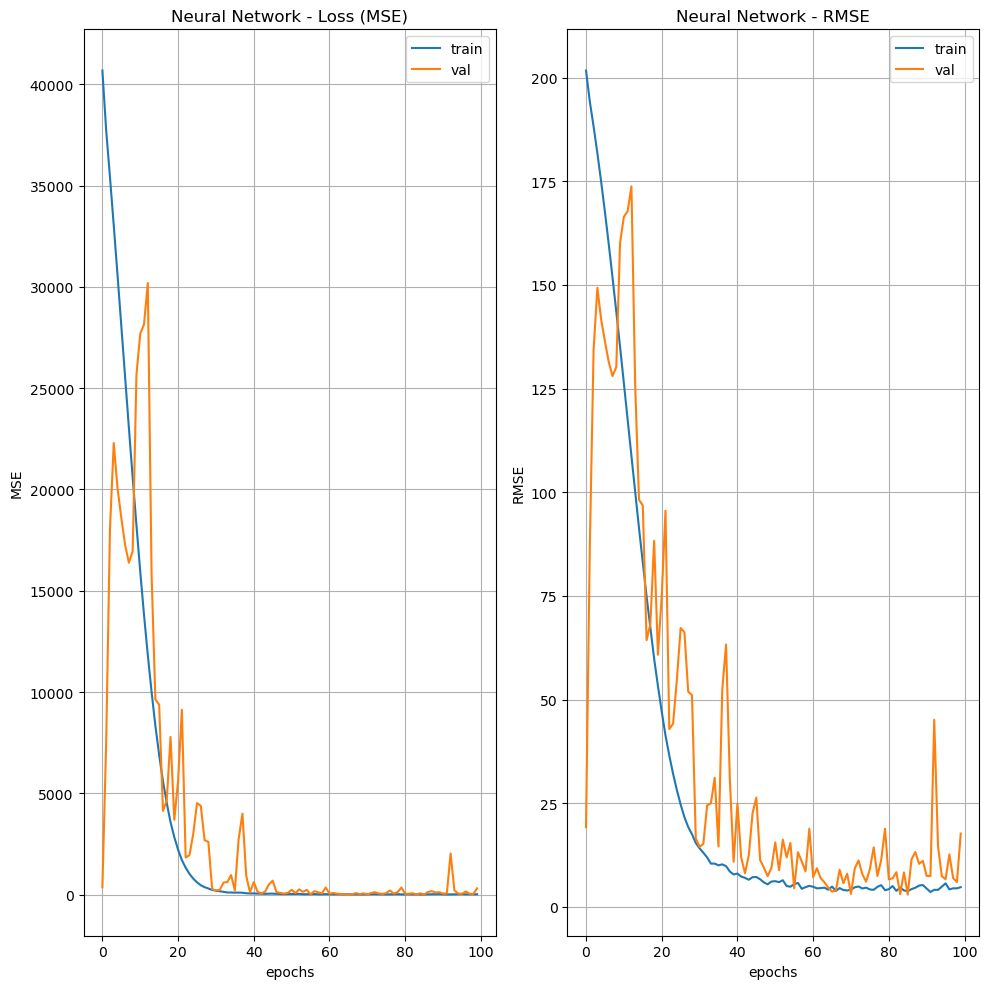

In [10]:
plt.figure(figsize=(10,10))


plt.subplot(1,2,1)
plt.plot(list(range(n_epochs)), history.history["loss"], label="train")
plt.plot(list(range(n_epochs)), history.history["val_loss"], label="val")
plt.title("Neural Network - Loss (MSE)")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(n_epochs)), history.history["root_mean_squared_error"], label="train")
plt.plot(list(range(n_epochs)), history.history["val_root_mean_squared_error"], label="val")
plt.title("Neural Network - RMSE")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()

plt.tight_layout()
plt.grid()
plt.savefig('Call_model_learning_curve.png')

In [11]:
call_y_pred =model.predict(call_X_test)

700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [12]:
print("MLP-1 model RMSE:\t",mean_squared_error(call_y_pred, call_y_test)**0.5)

MLP-1 model RMSE:	 17.29368262808156


In [13]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [14]:
# Extract necessary columns from the test set
S = call_X_test['underlying_value']*100 # rescaled 
K = call_X_test['strike_price']*100     # rescaled
T = call_X_test['t']/365                # always measured in years
r = call_X_test['r']
sigma = call_X_test['sigma']

# Compute Black-Scholes predictions
bs_predictions = black_scholes_call(S, K, T, r, sigma)


In [15]:
# Compute RMSE for Black-Scholes predictions
bs_rmse = mean_squared_error(call_y_test, bs_predictions, squared=False)
bs_rmse


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


100.08241410017231

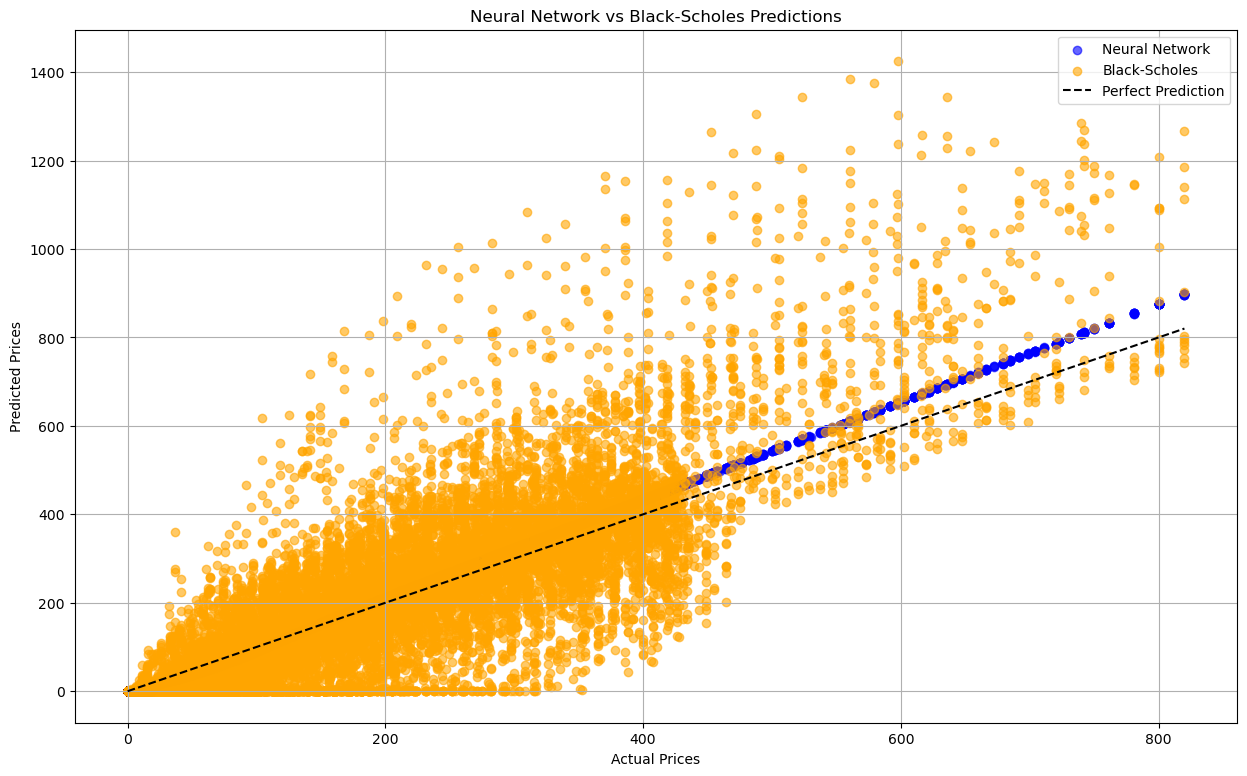

In [16]:
plt.figure(figsize=(15, 9))
# Scatter plot for NN predictions
plt.scatter(call_y_test, call_y_pred, alpha=0.6, label='Neural Network', color='blue')
# Scatter plot for Black-Scholes predictions
plt.scatter(call_y_test, bs_predictions, alpha=0.6, label='Black-Scholes', color='orange')

plt.plot([call_y_test.min(), call_y_test.max()], [call_y_test.min(), call_y_test.max()], 'k--', label="Perfect Prediction")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("Neural Network vs Black-Scholes Predictions")
plt.grid()
plt.show()